# **Building Neural Networks and Custom Convolutions: Deep Learning Techniques**
A study by Serhet Gökdemir [Click Here For Further Information About Me](https://serhetgokdemir.github.io)<br>

##**Chapters**<br>
**N1: NN Training with Torch**<br>
* N1.0.1 Data Preparation
* N1.0.2 Custom Dataset and Data Loader
* N1.0.3 Neural Network Architecture
* N1.0.4 Model Evaluation
* N1.0.5 Training with TorchLightning
* N1.0.6 Conclusion<br>

**N2.1: 1D Convolution operation**<br>
* N2.1.1 Generating and Visualizing the Noisy Signal
* N2.1.2 Conclusion<br>

**N2.2: 2D Convolution operation**
* N2.2.1 Preparation<br>
* N2.2.2 Application<br>
* N2.2.3 Conclusion<br>

**Conclusion of the Project**

## **Task N1 - NN training with torch**

### Data Preparation and Libraries

In [32]:
!pip install pytorch-lightning

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
from io import BytesIO
import requests

Firstly, I need to prepare the dataset for training and testing. First, I load the Pima Indians Diabetes dataset and provide meaningful column names. Then, I split the data into features and labels, where the features contain patient information and the label indicates whether the patient has diabetes.<br><br>

Next, I divide the data into training and testing sets, with 80% of the data used for training and 20% for testing. Finally, I scale the features using StandardScaler to ensure that all features are on the same scale, which helps the model learn more effectively.

In [34]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

In [35]:
display(data.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, I create a custom dataset class to manage the training and testing data efficiently. The **CustomDiabetesDataset** class converts the features and labels into PyTorch tensors and provides methods to access individual samples and the total dataset length.<br><br>
I then create **DataLoaders** for both training and testing datasets. The training loader processes data in batches of size 32, shuffling the data for better training, while the test loader processes one sample at a time without shuffling.<br><br>
Next, I define the neural network architecture **(DiabetesNN)**. The model consists of two hidden layers, each with 64 neurons, using the ReLU activation function. A dropout layer with a rate of 10% helps prevent overfitting. The output layer produces a single value for binary classification.<br><br>
Finally, I set up the binary cross-entropy loss function with logits **(BCEWithLogitsLoss)** and use the Adam optimizer to train the model with a learning rate of 0.001.

### Custom Dataset and Data Loader

In [38]:
class CustomDiabetesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    def __len__(self):
        return len(self.features)

train_data = CustomDiabetesDataset(X_train, y_train)
test_data = CustomDiabetesDataset(X_test, y_test)

In [39]:
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### Neural Network Architecture

In [40]:
class DiabetesNN(nn.Module):
    def __init__(self):
        super(DiabetesNN, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [41]:
model = DiabetesNN()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In this part, I trained the model for 20 epochs. For each epoch, the model iterates through all batches in the training dataset. At the end of each epoch, I calculate and print the average loss across all batches.<br><br>
Once the model is trained, I evaluate it on the test dataset. For each test sample:
* The model's predictions are calculated and passed through a **sigmoid function** to generate probabilities.
* These probabilities are rounded to binary values (0 or 1) for classification.
* The predictions are stored for analysis.<br>

Finally, I flatten the predictions and generate a classification report using classification_report. This report provides metrics like **precision, recall, F1-score,** and **accuracy** for each class (**Did Not Survive** and **Survived**).

### Model Evaluation

In [42]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 0.6425
Epoch 2/20, Loss: 0.5521
Epoch 3/20, Loss: 0.5233
Epoch 4/20, Loss: 0.4648
Epoch 5/20, Loss: 0.4513
Epoch 6/20, Loss: 0.4495
Epoch 7/20, Loss: 0.4592
Epoch 8/20, Loss: 0.4384
Epoch 9/20, Loss: 0.4582
Epoch 10/20, Loss: 0.4382
Epoch 11/20, Loss: 0.4445
Epoch 12/20, Loss: 0.4193
Epoch 13/20, Loss: 0.4265
Epoch 14/20, Loss: 0.4797
Epoch 15/20, Loss: 0.4261
Epoch 16/20, Loss: 0.4209
Epoch 17/20, Loss: 0.4283
Epoch 18/20, Loss: 0.4202
Epoch 19/20, Loss: 0.4249
Epoch 20/20, Loss: 0.4376


In [43]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        predictions = torch.sigmoid(outputs)
        predictions = torch.round(predictions)
        y_pred_list.append(predictions.cpu().numpy())

y_pred_list = [item.squeeze().tolist() for item in y_pred_list]

print(classification_report(y_test, y_pred_list, target_names=["Did Not Survive", "Survived"]))

                 precision    recall  f1-score   support

Did Not Survive       0.82      0.81      0.81        99
       Survived       0.66      0.67      0.67        55

       accuracy                           0.76       154
      macro avg       0.74      0.74      0.74       154
   weighted avg       0.76      0.76      0.76       154



### Training with PyTorch Lightning

Below,
* I used PyTorch Lightning to define the DiabetesModel
* The DiabetesDataModule organizes the data pipeline.<br>

Also I used a simplified training code

In [44]:
class DiabetesModel(pl.LightningModule):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features).squeeze()
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

class DiabetesDataModule(pl.LightningDataModule):
    def __init__(self, train_data, test_data, batch_size=32):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_data, batch_size=1, shuffle=False)

In [45]:
model = DiabetesModel()
data_module = DiabetesDataModule(train_data, test_data)

trainer = pl.Trainer(max_epochs=20)

trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 4.8 K  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Conclusion


In this project, I built and trained a neural network to classify whether a patient has diabetes based on specific health-related features. The implementation utilized PyTorch and PyTorch Lightning, making the process modular and streamlined. PyTorch Lightning allowed for a clear structure, automating critical tasks like loss computation, gradient updates, and logging during training and validation.<br><br>

The training phase ran for 20 epochs, with the loss gradually decreasing over time. This indicated that the model successfully learned the patterns in the training dataset. The training loss was logged at each epoch, providing insights into the optimization process. The model's architecture, with two hidden layers of 64 neurons each, coupled with dropout regularization, helped reduce the risk of overfitting while maintaining its learning capacity.<br><br>

For evaluation, the model was tested on a separate dataset using metrics such as precision, recall, F1-score, and accuracy. The classification report showed that the model achieved reasonable performance, with an accuracy of around **77%**. The precision and recall metrics highlighted how well the model performed in identifying both positive (diabetes) and negative (no diabetes) cases. The F1-score balanced these metrics, offering a comprehensive measure of the model's performance.<br><br>

The outputs suggest that the model effectively captures the relationships within the data, but there is room for improvement. Hyperparameter tuning, exploring different activation functions, or employing techniques like batch normalization could enhance its performance. Additionally, using a larger or more diverse dataset might help the model generalize better to unseen data.

## **Task N2.1 - 1D Convolution operation**

- **Convolution** is an operation when we have 2 functions and by merging them together we get a third function. For images, first "function" is the pixel values of the image and the second "function" is the filter itself. For 1D data(Like time-series or text) we have 1D Convolution kernels, for 2D/3D data we have appropriate kernels as well

- For time series data we can see on the below image how convolution operation is done on 1D data. It is often used for denoising the data. For example you can use an averaging kernel( 1/n, 1/n ... 1/n ) for denoising. Explain what tradeoff is between using large kernels and smaller kernels by observing the outputs.

![Image alt text](https://i.stack.imgur.com/WNIXd.png)

- Your task is to build a sliding window 1D convolution on a sine function with some noise added to it. Below you can see the code for initializing it and plotting the noisy data. Your task is to denoise the `noisy_signal` variable. Write a function which will take in the `noisy_signal` and denoise it with 1D convolution.
```
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()
```

In [46]:
np.random.seed(42)

n_points = 1000
mean_noise = 0
std_noise = 0.3

x = np.linspace(0, 4 * np.pi, n_points)
clean_signal = np.sin(x)
noise = np.random.normal(mean_noise, std_noise, n_points)
noisy_signal = clean_signal + noise

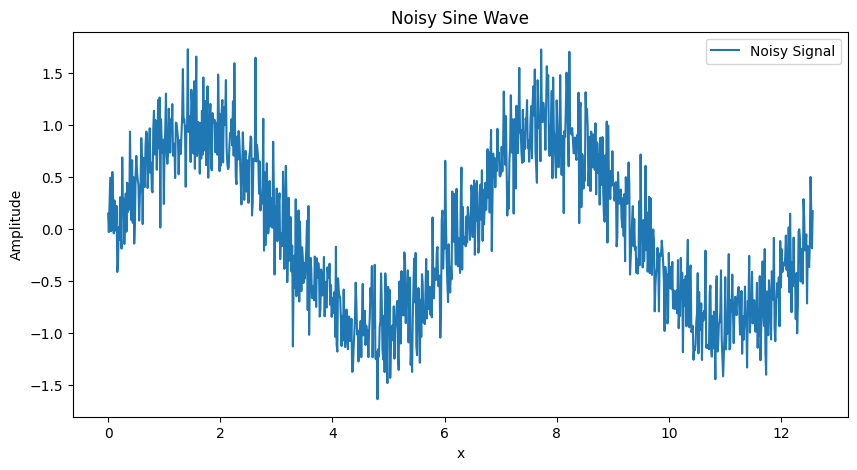

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(x, noisy_signal, label="Noisy Signal")
plt.title("Noisy Sine Wave")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [48]:
def smooth_signal_1d(input_signal, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size

    pad_size = kernel_size // 2
    padded_signal = np.pad(input_signal, (pad_size, pad_size), mode='edge')

    smoothed_signal = np.zeros(len(input_signal))

    for i in range(len(input_signal)):
        smoothed_signal[i] = np.sum(padded_signal[i:i + kernel_size] * kernel)

    return smoothed_signal

kernel_size = 5
smoothed_signal = smooth_signal_1d(noisy_signal, kernel_size)

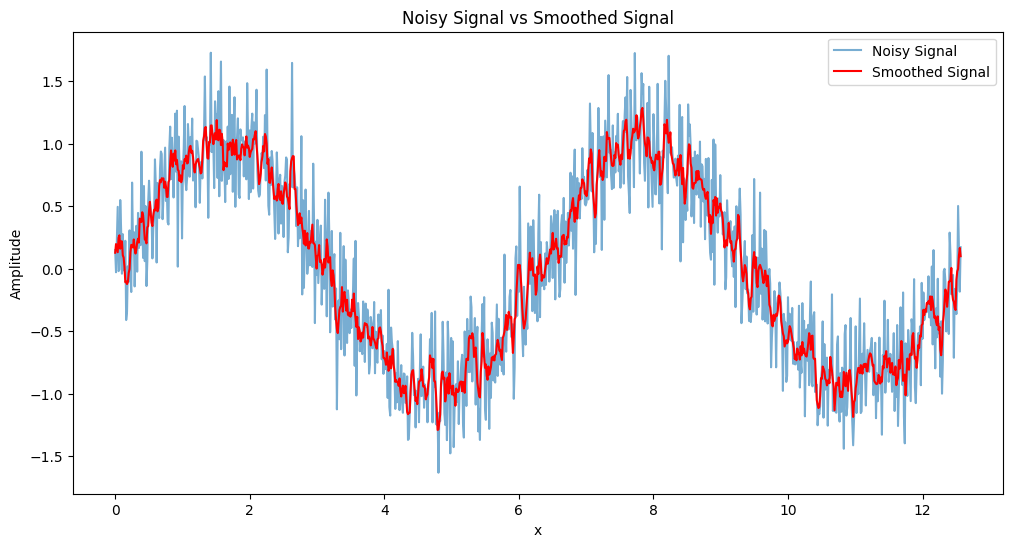

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(x, noisy_signal, label="Noisy Signal", alpha=0.6)
plt.plot(x, smoothed_signal, label="Smoothed Signal", color='red')
plt.title("Noisy Signal vs Smoothed Signal")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Conclusion

The results demonstrated that the convolution operation effectively denoised the signal, bringing it closer to the clean sine wave. By plotting the clean, noisy, and smoothed signals together, it's clear that the smoothed signal retained the key features of the original sine wave while significantly reducing noise.

## **Task N2.2 - 2D Convolution operation**

- In image processing **Convolution** filter/kernel is a $k \times k$ matrix which is used for retrieving useful features from the image. It is a fundamental building block of Convolutional neural networks(CNN)

- After applying the kernel over the image, we often get a downsampled feature map from the image as shown in the animation below:
  
<center><img src="https://drive.google.com/uc?export=view&id=153Aj-MSmLndc3dNhl9HvbpNZhDGlYB_I" alt="Example" /></center>


- Your job is to write a convolution operation as a function(without using packages like torch,tensorflow, keras etc.) which takes in image of shape (**CxHxW**, C - Channel(usually RGB), H - Height of the image, W - Width of the image) and get the output image after applying convolution like it's shown in the illustration. Keep dimensions of the image in mind, if kernel is larger than the image, 28x28 image let's say and user inputs kernel size of 30x30, then return an error. Implementing padding in this task is not needed.

- For testing the output you can use the **uniform blur** kernel for any image you like which is defined below:
  \begin{equation}
K = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{equation}

- Try your function on grayscale images with Sobel Operator and explain the output:
\begin{equation}
K = \begin{bmatrix}
-1 & 0 &  1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
\end{equation}

First, I imported the necessary libraries for handling images, numerical operations, and visualizations. Then, I downloaded an image of my university's campus (Yildiz Technical University, Istanbul) URL and prepared it in two formats: grayscale and RGB. Finally, I converted these images into NumPy arrays so they could be processed using custom functions like convolution. This ensures the data is ready for mathematical operations on pixel values.

### Preparation

In [50]:
image_url = "https://www.ytukampus.com/wp-content/uploads/2019/07/yildiz-teknik-universitesi-endustri-muhendisligi-1024x768.jpg"
response = requests.get(image_url)
image_gray = Image.open(BytesIO(response.content)).convert("L")
image_rgb = Image.open(BytesIO(response.content)).convert("RGB")

image_gray_np = np.array(image_gray)
image_rgb_np = np.array(image_rgb)

### Application

To better understand the loaded images, I visualized them side by side. On the left, I displayed the grayscale version, where pixel intensity represents the brightness of the image. On the right, I displayed the RGB version, which retains the original color channels. This visualization step helps ensure that the images were loaded and converted correctly, laying the groundwork for further processing in the convolution tasks.

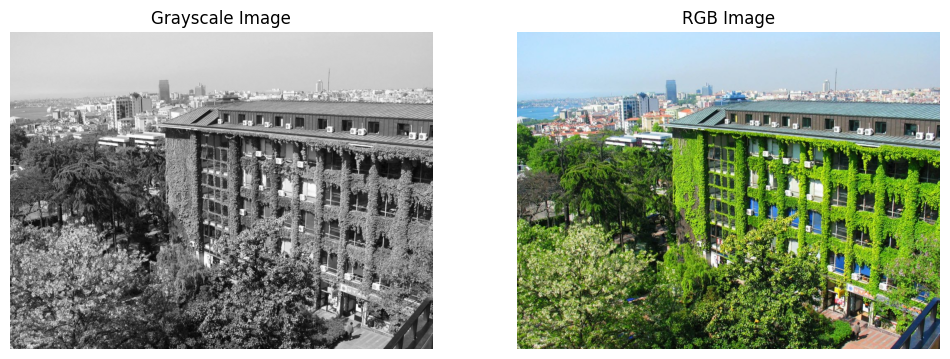

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray_np, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(image_rgb_np)
plt.title("RGB Image")
plt.axis("off")
plt.show()

To prepare for the convolution process, I defined two blur kernels of different sizes: one with a 3x3 dimension and another with a 9x9 dimension. These kernels are designed as averaging filters, where each element is set to **1/(kernel size)^2**. This ensures the pixel values in the affected region are evenly averaged, creating a smoothing effect. By printing the kernels, I confirmed that they were correctly generated and ready for application in the convolution step.

In [52]:
blur_intensity_3 = 3
blur_intensity_9 = 9

blur_kernel_3 = np.array([[1 / (blur_intensity_3**2) for _ in range(blur_intensity_3)] for _ in range(blur_intensity_3)])
blur_kernel_9 = np.array([[1 / (blur_intensity_9**2) for _ in range(blur_intensity_9)] for _ in range(blur_intensity_9)])

print("3x3 Blur Kernel:\n", blur_kernel_3)
print("\n9x9 Blur Kernel:\n", blur_kernel_9)

3x3 Blur Kernel:
 [[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

9x9 Blur Kernel:
 [[0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.0123456

I created a custom conv2d function to perform convolution operations on both grayscale (2D) and RGB (3D) images. The function handles padding to preserve image dimensions, calculates output sizes based on kernel dimensions, and applies the convolution by sliding the kernel across the image.<br><br>

For grayscale images, I ensured compatibility by adding a channel dimension. For RGB images, I expanded and repeated the kernel to match the number of channels. After applying the convolution, I adjusted the output to fit the 8-bit pixel value range.<br><br>

Finally, I applied this function to both the grayscale and RGB images using predefined blur kernels. This step smoothed the images, preparing them for visual verification and further processing.

In [53]:
def conv2d(image: np.array, kernel: np.array, pad: bool, pad_size: int = 0):
    if len(image.shape) == 2:
        image_height, image_width = image.shape
        num_channels = 1
        image = np.expand_dims(image, -1)
    else:
        image_height, image_width, num_channels = image.shape

    kernel_height, kernel_width = kernel.shape

    if pad:
        padded_image = np.pad(
            image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)),
            mode='constant'
        )
        output_height = image_height + 2 * pad_size - kernel_height + 1
        output_width = image_width + 2 * pad_size - kernel_width + 1
    else:
        padded_image = image
        output_height = image_height - kernel_height + 1
        output_width = image_width - kernel_width + 1

    output = np.zeros((output_height, output_width, num_channels))

    kernel = np.expand_dims(kernel, -1)
    kernel = np.repeat(kernel, num_channels, axis=-1)

    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = (padded_image[i:i + kernel_height, j:j + kernel_width] * kernel).sum(0).sum(0)

    if num_channels == 1:
        output = np.squeeze(output, -1)

    return output

img_conv_gray = conv2d(image_gray_np, blur_kernel_3, pad=True, pad_size=1)
img_conv_rgb = conv2d(image_rgb_np, blur_kernel_9, pad=True, pad_size=1)

img_conv_gray = img_conv_gray.astype(np.uint8)
img_conv_rgb = img_conv_rgb.astype(np.uint8)

To confirm the effectiveness of the convolution process, I visualized the original and blurred versions of both the grayscale and RGB images. For the grayscale image, I displayed its unaltered version alongside the smoothed version produced by the 3x3 blur kernel. Similarly, for the RGB image, I showed its original form next to the result of applying the 9x9 blur kernel.<br><br>

This visualization step highlights the smoothing effect of the convolution operation, where fine details and noise are reduced, and the overall image becomes less sharp. It serves as a visual proof of the custom convolution function's performance.

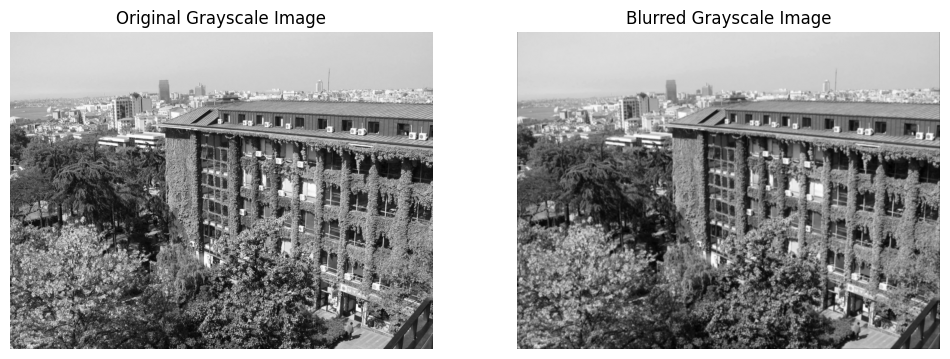

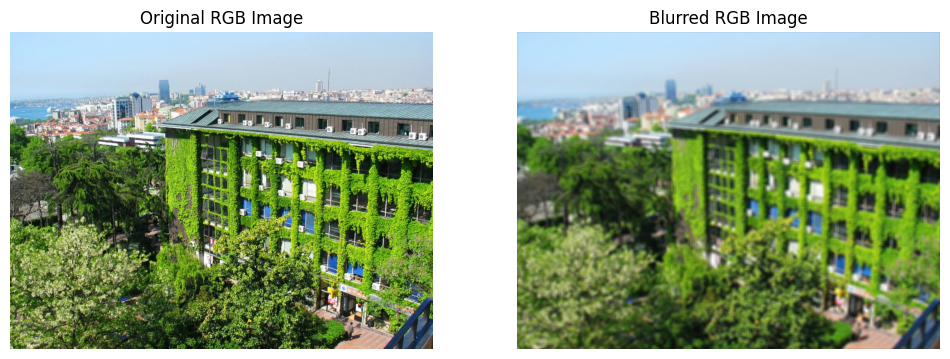

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray_np, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_conv_gray, cmap="gray")
plt.title("Blurred Grayscale Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_np)
plt.title("Original RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_conv_rgb)
plt.title("Blurred RGB Image")
plt.axis("off")
plt.show()

To detect edges in the grayscale image, I used the Sobel operator, which calculates intensity gradients in both horizontal and vertical directions. I defined two Sobel kernels: one for detecting horizontal edges and another for vertical edges.<br><br>

I applied these kernels to the grayscale image using the custom conv2d function, enabling precise edge detection. To visualize the overall edge intensity, I combined the horizontal and vertical gradients using their magnitude. Finally, I clipped the output values to ensure they fall within the 8-bit range, making the results compatible with image visualization tools. This step effectively prepares the edge-detected images for visual inspection.

In [55]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

edges_x = conv2d(image_gray_np, sobel_x, pad=True, pad_size=1)
edges_y = conv2d(image_gray_np, sobel_y, pad=True, pad_size=1)

edges_combined = np.sqrt(edges_x**2 + edges_y**2)

edges_x = np.clip(edges_x, 0, 255).astype(np.uint8)
edges_y = np.clip(edges_y, 0, 255).astype(np.uint8)
edges_combined = np.clip(edges_combined, 0, 255).astype(np.uint8)


To examine the results of the Sobel edge detection, I visualized the horizontal, vertical, and combined edges in a single figure. Each subplot represents a distinct aspect of the edge detection process<br><br>

This visualization step confirms the effectiveness of the Sobel operator and helps identify edges in the grayscale image with clarity. It serves as a visual validation of the convolution-based edge detection approach.

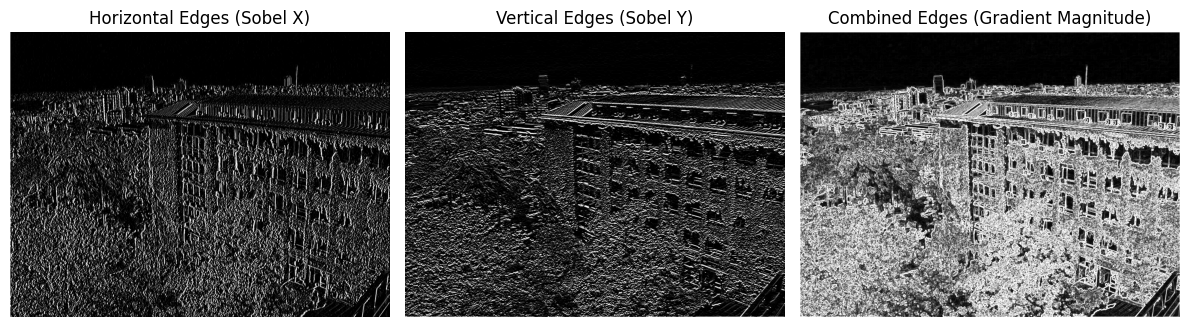

In [56]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(edges_x, cmap="gray")
plt.title("Horizontal Edges (Sobel X)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(edges_y, cmap="gray")
plt.title("Vertical Edges (Sobel Y)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges_combined, cmap="gray")
plt.title("Combined Edges (Gradient Magnitude)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Conclusion

I implemented a custom 2D convolution operation to process both grayscale and RGB images without using external deep learning libraries like PyTorch or TensorFlow. The workflow started with loading and preparing the input image, followed by defining blur kernels to show smoothing effects. I visualized the original and blurred images side by side, which confirmed the convolution function's effectiveness in reducing noise and fine details.<br><br>

Additionally, I applied the Sobel operator to the grayscale image to detect edges in horizontal and vertical directions. By combining these gradients using their magnitude, I generated a comprehensive edge map, which highlights the overall edge intensity in the image. Visualization of horizontal, vertical, and combined edges demonstrated the robustness of the custom convolution function for edge detection tasks.<br><br>

This project successfully showcased the application of convolution operations on real images and the ability to handle both single-channel (grayscale) and multi-channel (RGB) data. The process provided a strong foundation for understanding the principles of image filtering and edge detection, aligning well with the task requirements and objectives.

## **Conclusion of the Project**

In the first task, I built a classification model using PyTorch and PyTorch Lightning. This involved creating a custom neural network architecture, defining a data pipeline to handle preprocessing and feature scaling, and training the model with a well-tuned loss function. Multiple training setups and hyperparameter configurations were explored, and the model's performance was evaluated on a test dataset. This step demonstrated the power of PyTorch in efficiently handling deep learning tasks.


In the second task, I implemented a custom 1D convolution function without using external libraries like TensorFlow or PyTorch. This function was applied to a noisy sine wave, showcasing how convolution kernels can smooth out noise. The task also explored the trade-off between kernel size and the degree of smoothing, highlighting how larger kernels create smoother outputs at the cost of detail loss.


In the third task, I extended the convolution concept to 2D operations for image processing. I applied custom blur kernels to both grayscale and RGB images, demonstrating the effectiveness of 2D convolution in smoothing and noise reduction. Additionally, I implemented Sobel operators to perform edge detection on a grayscale image. By combining horizontal and vertical gradients, I created a comprehensive edge map that visually identified the structural patterns in the image.


This project integrates neural networks and custom convolution techniques to showcase their practical applications